# Sparse Autoencoder

當在訓練一個普通的 `autoenoder` 時，如果嘗試丟入一些輸入，會看到中間許多的神經元 (hidden unit) 大部分都會有所反應 (activate)．反應的意思是這個神經元的輸出不會等於零，也不會很接近零，而是大於零許多．白話的意思就是神經元說：「咦！這個輸入我認識噢～」

然而我們是不想要看到這樣的情形的！我們想要看到的情形是每個神經元只對一些些訓練輸入有反應．例如手寫數字 0-9，那神經元 A 只對數字 5 有反應，神經元 B 只對 7 有反應 ... 等．為什麼要這樣的結果呢？在 [Quora](https://www.quora.com/Why-are-sparse-autoencoders-sparse) 上面有一個解說是這樣的

> 如果一個人可以做 A, B, C ... 許多的工作，那他就不太可能是 A 工作的專家，或是 B 工作的專家．
> 如果一個神經元對於每個不同的訓練都會有反應，那有它沒它好像沒有什麼差別

所以接下來要做的事情就是加上稀疏的限制條件 (sparse constraint)，來訓練出 `Sparse Autoencoder`．而要在哪裡加上這個限制呢？就是要在 loss 函數中做手腳．在這裡我們會加上兩個項，分別是：

* Sparsity Regularization
* L2 Regularization

## Sparsity Regularization

這一項我們想要做的事就是讓 autoencoder 中每個神經元的輸出變小，而實際上的做法則是如下
**先設定一個值，然後讓平均神經元輸出值 (average output activation vlue) 越接近它越好，如果偏離這個值，cost 函數就會變大，達到懲罰的效果**

$$
\hat{\rho_{i}} = \frac{1}{n} \sum_{j = 1}^{n} h(w_{i}^{T}  x_{j} + b_{i}) \\
\hat{\rho_{i}} : \text{ average output activation value of a neuron i} \\
n: \text{ total number of training examples} \\
x_{j}: \text{jth training example} \\
w_{i}^{T}: \text{ith row of  the weight matrix W} \\
b_{i}: \text{ith entropy of the bias vector} \\
$$

### Kullback-Leibler divergence (relative entropy)

$$
\Omega_{sparsity} = \sum_{i=1}^{D}\rho\log(\frac{\rho}{\hat{\rho_{i}}})+(1-\rho)\log(\frac{1-\rho}{1-\hat{\rho_{i}}}) \\
\hat{\rho_{i}} : \text{ average output activation value of a neuron i}
$$

Kullback-Leibler divergence 是用來計算兩個機率分佈接近的程度，如果兩個一樣的話就為 0．我們可以看以下的例子，設定值 rho_hat 為 0.2，而 rho 等於 0.2 的時候 kl_div = 0，rho 等於其他值時 kl_div 大於 0．

而在實例上，就讓 rho 以 average output activation 取代．


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


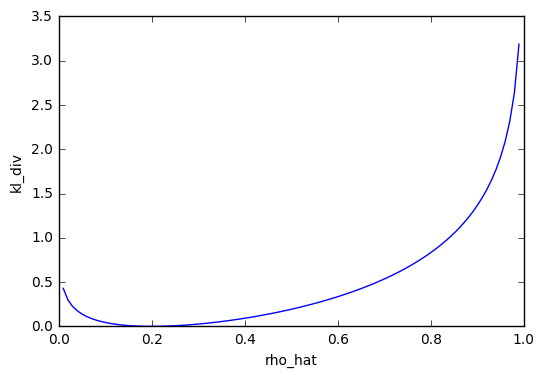

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)

rho_hat = np.linspace(0 + 1e-2, 1 - 1e-2, 100)
rho = 0.2
kl_div = rho * np.log(rho/rho_hat) + (1 - rho) * np.log((1 - rho) / (1 - rho_hat))
plt.plot(rho_hat, kl_div)
plt.xlabel("rho_hat")
plt.ylabel("kl_div")

### L2 Regularization
經過了 Sparsity Regularization 這一項，理想上神經元輸出會接近我們所設定的值．而這裡想要達到的目標就是讓 weight 盡量的變小，讓整個模型變得比較簡單，而不是 weight 變大，使得 bias 要變得很大來修正．
$$
\Omega_{weights} = \frac{1}{2}\sum_{l}^{L}\sum_{j}^{n}\sum_{i}^{k}(w_{ji}^{(l)})^{2} \\
L : \text{number of the hidden layers} \\
n : \text{number of observations} \\
k : \text{number of variables in training data}
$$

### cost 函數

cost 函數就是把這幾項全部加起來，來 minimize 它．

$$
E = \Omega_{mse} + \beta * \Omega_{sparsity} + \lambda * \Omega_{weights}
$$

在 tensorflow 裡面有現成的函數 `tf.nn.l2_loss` 可以使用，把單一層的 l2_loss 計算出來，舉個例子，如果有兩層隱層權重 `w1`, `w2`，則要把兩個加總：`tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2)`

In [2]:
def weight_variable(shape, name):
    return tf.Variable(tf.truncated_normal(shape = shape, stddev = 0.1), name)
def bias_variable(shape, name):
    return tf.Variable(tf.zeros(shape = shape), name)

In [3]:
def plot_n_reconstruct(origin_img, reconstruct_img, n = 10):

    plt.figure(figsize=(2 * 10, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(origin_img[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstruct_img[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

## 實作
我們會先建立一個一般的 autoencoder，之後再建立一個 sparse autoencoder，並比較它輸出的影像以及 average activation output value．
### Normal Autoencoder
建立 784 -> 300 -> 30 -> 300 -> 784 Autoencoder，

In [4]:
def build_sae():
    W_e_1 = weight_variable([784, 300], "w_e_1")
    b_e_1 = bias_variable([300], "b_e_1")
    h_e_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, W_e_1), b_e_1))

    W_e_2 = weight_variable([300, 30], "w_e_2")
    b_e_2 = bias_variable([30], "b_e_2")
    h_e_2 = tf.nn.sigmoid(tf.add(tf.matmul(h_e_1, W_e_2), b_e_2))

    W_d_1 = weight_variable([30, 300], "w_d_1")
    b_d_1 = bias_variable([300], "b_d_1")
    h_d_1 = tf.nn.sigmoid(tf.add(tf.matmul(h_e_2, W_d_1), b_d_1))

    W_d_2 = weight_variable([300, 784], "w_d_2")
    b_d_2 = bias_variable([784], "b_d_2")
    h_d_2 = tf.nn.sigmoid(tf.add(tf.matmul(h_d_1, W_d_2), b_d_2))
    
    return [h_e_1, h_e_2], [W_e_1, W_e_2, W_d_1, W_d_2], h_d_2


In [5]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
x = tf.placeholder(tf.float32, shape = [None, 784])
h, w, x_reconstruct = build_sae()

loss = tf.reduce_mean(tf.pow(x_reconstruct - x, 2))
optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)
init_op = tf.global_variables_initializer()

sess.run(init_op)

for i in range(20000):
    batch = mnist.train.next_batch(60)
    if i < 1500:
        if i%100 == 0:
            print("step %d, loss %g"%(i, loss.eval(feed_dict={x:batch[0]})))
    else:
        if i%1000 == 0: 
            print("step %d, loss %g"%(i, loss.eval(feed_dict={x:batch[0]})))
    optimizer.run(feed_dict={x: batch[0]})
print("final loss %g" % loss.eval(feed_dict={x: mnist.test.images}))

step 0, loss 0.261328
step 100, loss 0.0668037
step 200, loss 0.0556549
step 300, loss 0.0601463
step 400, loss 0.0533607
step 500, loss 0.0471783
step 600, loss 0.0411026
step 700, loss 0.035155
step 800, loss 0.0339428
step 900, loss 0.0282643
step 1000, loss 0.029779
step 1100, loss 0.0269303
step 1200, loss 0.0253905
step 1300, loss 0.026927
step 1400, loss 0.0223757
step 2000, loss 0.0222608
step 3000, loss 0.0145288
step 4000, loss 0.0147411
step 5000, loss 0.0142414
step 6000, loss 0.0126185
step 7000, loss 0.0107994
step 8000, loss 0.0106894
step 9000, loss 0.0121361
step 10000, loss 0.0126073
step 11000, loss 0.0114935
step 12000, loss 0.00952163
step 13000, loss 0.0110226
step 14000, loss 0.0113799
step 15000, loss 0.0088239
step 16000, loss 0.0102227
step 17000, loss 0.0109529
step 18000, loss 0.0104999
step 19000, loss 0.0106634
final loss 0.0102131


#### average output activation value
印出 encoder 中第一層以及第二層的 `average output activation value`

In [6]:
for h_i in h:
    print("average output activation value %g" % tf.reduce_mean(h_i).eval(feed_dict={x: mnist.test.images}))

average output activation value 0.223044
average output activation value 0.372151


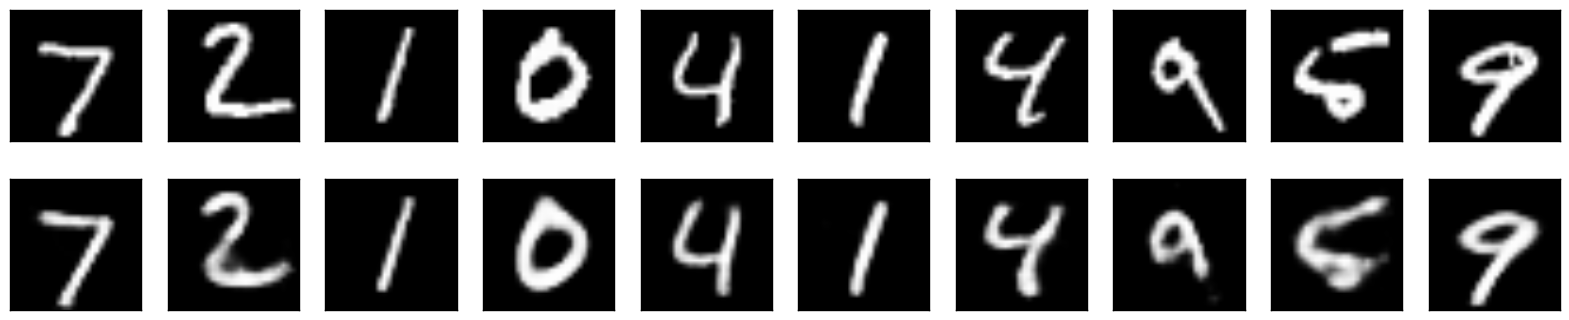

In [7]:
test_size = 10
test_origin_img = mnist.test.images[0:test_size, :]
test_reconstruct_img = x_reconstruct.eval(feed_dict = {x: test_origin_img})
plot_n_reconstruct(test_origin_img, test_reconstruct_img)

## Sparse Autoencoder
### KL divergence function
依照公式建立 kl_div 函數

In [8]:
def kl_div(rho, rho_hat):
    invrho = tf.sub(tf.constant(1.), rho)
    invrhohat = tf.sub(tf.constant(1.), rho_hat)
    logrho = tf.add(logfunc(rho,rho_hat), logfunc(invrho, invrhohat))
    return logrho
    
def logfunc(x, x2):
    return tf.mul( x, tf.log(tf.div(x,x2)))

### loss function
把三個 loss 全部加起來，並乘以對應的係數

In [9]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
x = tf.placeholder(tf.float32, shape = [None, 784])
h, w, x_reconstruct = build_sae()

alpha = 5e-6
beta = 7.5e-5
kl_div_loss = reduce(lambda x, y: x + y, map(lambda x: tf.reduce_sum(kl_div(0.02, tf.reduce_mean(x,0))), h))
#kl_div_loss = tf.reduce_sum(kl_div(0.02, tf.reduce_mean(h[0],0)))
l2_loss = reduce(lambda x, y: x + y, map(lambda x: tf.nn.l2_loss(x), w))

loss = tf.reduce_mean(tf.pow(x_reconstruct - x, 2)) + alpha * l2_loss + beta * kl_div_loss
optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)
init_op = tf.global_variables_initializer()

sess.run(init_op)

for i in range(20000):
    batch = mnist.train.next_batch(60)
    if i < 1500:
        if i%100 == 0:
            print("step %d, loss %g"%(i, loss.eval(feed_dict={x:batch[0]})))
    else:
        if i%1000 == 0: 
            print("step %d, loss %g"%(i, loss.eval(feed_dict={x:batch[0]})))
    optimizer.run(feed_dict={x: batch[0]})
    
print("final loss %g" % loss.eval(feed_dict={x: mnist.test.images}))


step 0, loss 0.291167
step 100, loss 0.076417
step 200, loss 0.0612264
step 300, loss 0.0583587
step 400, loss 0.0563758
step 500, loss 0.0529813
step 600, loss 0.046916
step 700, loss 0.0482076
step 800, loss 0.0456496
step 900, loss 0.0431564
step 1000, loss 0.0435454
step 1100, loss 0.0387787
step 1200, loss 0.0409411
step 1300, loss 0.0402909
step 1400, loss 0.0389212
step 2000, loss 0.0401633
step 3000, loss 0.038092
step 4000, loss 0.0353613
step 5000, loss 0.0357929
step 6000, loss 0.0350644
step 7000, loss 0.0365562
step 8000, loss 0.0383229
step 9000, loss 0.0375741
step 10000, loss 0.0380063
step 11000, loss 0.0364174
step 12000, loss 0.0376087
step 13000, loss 0.0354256
step 14000, loss 0.0347151
step 15000, loss 0.0372976
step 16000, loss 0.0369707
step 17000, loss 0.0356938
step 18000, loss 0.0360995
step 19000, loss 0.0344233
final loss 0.035359


#### average output activation value
印出 encoder 中第一層以及第二層的 `average output activation value`

In [10]:
for h_i in h:
    print("average output activation value %g" % tf.reduce_mean(h_i).eval(feed_dict={x: mnist.test.images}))


average output activation value 0.0513545
average output activation value 0.389197


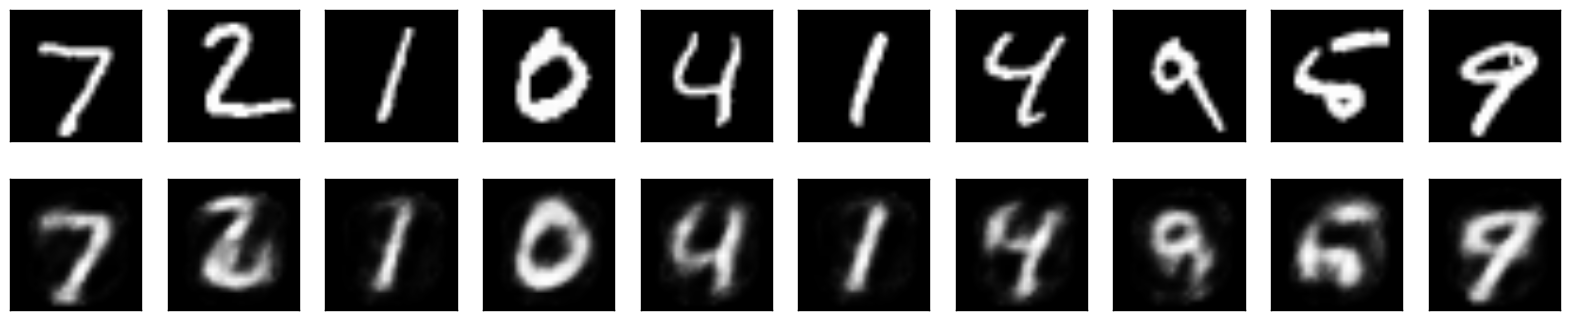

In [11]:
test_size = 10
test_origin_img = mnist.test.images[0:test_size, :]
test_reconstruct_img = x_reconstruct.eval(feed_dict = {x: test_origin_img})
plot_n_reconstruct(test_origin_img, test_reconstruct_img)

圖片結果可以看到它和普通的 autoencoder 差不多，但是稍微糊了一點，而第一層的 average output activation value 從 0.19 降到了 0.05，第二層的值反而上升了一點點．這個部分的調整跟 hyperparameter 有很大的關係，如果我把 beta 調大，第一第二層的 average output activation value 會接近 0.02，但是輸出的圖像會變模糊．`beta = 7.5e-5` 是我試了幾次以後比較平衡兩者的結果．

## 小結

我們實現了 KL Divergence 以及 L2 loss，並把這兩個項加入了 loss，成為了 sparse autoencoder．最後的結果會看到 average output activation value 是有明顯下降的．

而整個過程需要花比較多時間的地方是在 hyperparameter 的調整，調太大或者調太小，都會沒辦法達到預期的效果．

#### 問題

* 如果改用 L1 loss 的結果?
* 有沒有更好的方法來決定 hyperparameter?
* 這裡的 activation function 都是 sigmoid，如果用 ReLU?

## 學習資源連結

* [Matlab Autoencoder Doc](https://www.mathworks.com/help/nnet/ref/trainautoencoder.html#buythqy)
* [Sparse Autoencoder in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)